# BEH Trial Exclusion
Status: Implemented
 -- Fully automatized

In [1]:
from tqdm.notebook import tqdm
from utils.utils import *

In [2]:
# get all files from participants
folders = get_participant_folder_per_participant()
print(folders)

{'003': WindowsPath('../08-Data-Trial_Recordings/raw/E003'), '004': WindowsPath('../08-Data-Trial_Recordings/raw/E004'), '005': WindowsPath('../08-Data-Trial_Recordings/raw/E005'), '007': WindowsPath('../08-Data-Trial_Recordings/raw/E007'), '008': WindowsPath('../08-Data-Trial_Recordings/raw/E008'), '009': WindowsPath('../08-Data-Trial_Recordings/raw/E009'), '010': WindowsPath('../08-Data-Trial_Recordings/raw/E010'), '011': WindowsPath('../08-Data-Trial_Recordings/raw/E011'), '012': WindowsPath('../08-Data-Trial_Recordings/raw/E012'), '013': WindowsPath('../08-Data-Trial_Recordings/raw/E013'), '014': WindowsPath('../08-Data-Trial_Recordings/raw/E014'), '015': WindowsPath('../08-Data-Trial_Recordings/raw/E015'), '016': WindowsPath('../08-Data-Trial_Recordings/raw/E016'), '017': WindowsPath('../08-Data-Trial_Recordings/raw/E017'), '018': WindowsPath('../08-Data-Trial_Recordings/raw/E018'), '019': WindowsPath('../08-Data-Trial_Recordings/raw/E019'), '020': WindowsPath('../08-Data-Trial_Re

### Check exclusion criteria for behavioral data 
* response time outside E+-3std
* correctness per participant higher expected value using chance 

(01/05) Load behavioral data from all participants
(02/05) Check participant correctness
Correctness subjectwise mean: 79.33 % , std: 8.64 %


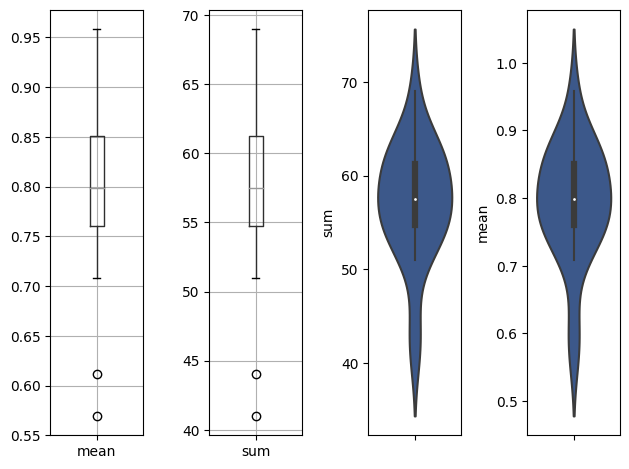

(03/05) Mark as excluded
----------------------------------------------
Participant 003
Correctness: 61 snippets, 84.72 %
----------------------------------------------
Participant 004
Correctness: 55 snippets, 76.39 %
----------------------------------------------
Participant 005
Correctness: 54 snippets, 75.0 %
----------------------------------------------
Participant 007
Correctness: 63 snippets, 87.5 %
----------------------------------------------
Participant 008
Correctness: 62 snippets, 86.11 %
----------------------------------------------
Participant 009
Correctness: 63 snippets, 87.5 %
----------------------------------------------
Participant 010
Correctness: 69 snippets, 95.83 %
----------------------------------------------
Participant 011
Correctness: 61 snippets, 84.72 %
----------------------------------------------
Participant 012
Correctness: 55 snippets, 76.39 %
----------------------------------------------
Participant 013
Correctness: 52 snippets, 72.22 %
--------

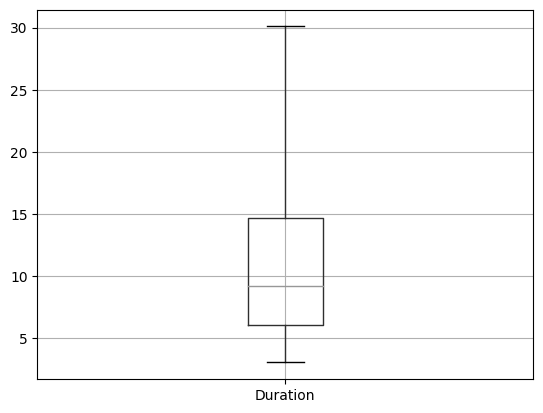

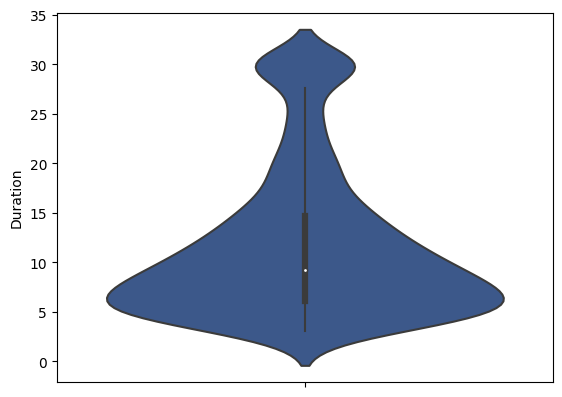

Acceptance rate: 1.0
(05/05) Mark as excluded


In [3]:
# Analyze data across all participants
print('(01/05) Load behavioral data from all participants')
behavioral_data = get_all_behavioral_data(
    {participant: get_behavioral_data_path(participant, final_data_exclusion=False) for participant in folders})

print('(02/05) Check participant correctness')
correctness_data = check_correctness(behavioral_data)
fig, axes = plt.subplots(1, 4)
print('Correctness subjectwise mean:',
      round(correctness_data['mean'].mean()*100, 2), '%',
      ', std:', round(correctness_data['mean'].std()*100, 2), '%')
correctness_data.boxplot(column=['mean'], ax=axes[0])
correctness_data.boxplot(column=['sum'], ax=axes[1])
sns.violinplot(correctness_data, y='sum', ax=axes[2])
sns.violinplot(correctness_data, y='mean', ax=axes[3])
fig.tight_layout()
plt.show()

print('(03/05) Mark as excluded')
for participant, row in correctness_data.iterrows():
    print('----------------------------------------------')
    print(PARTICIPANT, participant)
    print(BEHAVIORAL_COLUMN_CORRECTNESS+':', row['sum'], 'snippets,',
          round(row['mean']*100, 2), '%')
    if not row[ACCEPTED]:
        print('\texcluded participant')
        update_exclusions(participant, PARTICIPANT, BEHAVIORAL, {
                          BEHAVIORAL_COLUMN_CORRECTNESS: '01c2_PRE_BEH_Trial_Exclusion: Correctness too low'})

print('(04/05) Calculate acceptance interval for duration according to Tukey (E+-3 std)')
behavioral_data = calculate_duration_acceptance(behavioral_data)

print('(05/05) Mark as excluded')
unaccepted = behavioral_data[~behavioral_data[ACCEPTED]]
for participant in unaccepted[PARTICIPANT].unique():
    print('----------------------------------------------')
    print(PARTICIPANT, participant, type(participant))
    snippets = unaccepted[unaccepted[PARTICIPANT]
                          == participant][SNIPPET].to_list()
    update_exclusions(participant, SNIPPET, BEHAVIORAL, {
                      s: '01c2_PRE_BEH_Trial_Exclusion: Behavioral value outside tukey interval' for s in snippets})

In [4]:
participant_data = []
for participant in tqdm(folders):
    print('----------------------------------------------')
    print(PARTICIPANT, participant)

    print('(01/04) Load behavioral data')
    behavioral_data = pd.read_csv(get_behavioral_data_path(
        participant, final_data_exclusion=False), sep=SEPARATOR, index_col=False, dtype={PARTICIPANT: str})

    print('(02/04) Load exclusions')
    exclusions = get_exclusions(
        participant, [PARTICIPANT, SNIPPET], [BEHAVIORAL])
    excluded_participant: list[str] = exclusions[PARTICIPANT][BEHAVIORAL]
    excluded_snippets: dict[str, list[str]] = {snippet: exclusions[SNIPPET][snippet][BEHAVIORAL]
                                               for snippet in exclusions[SNIPPET] if exclusions[SNIPPET][snippet][BEHAVIORAL]}

    print('(03/04) Remove excluded snippets')
    if excluded_participant:
        print(f'\tExclude participant')
        behavioral_data = behavioral_data.drop(behavioral_data.index)
    else:
        if excluded_snippets:
            possible_reasons = set(
                r for reasons in excluded_snippets.values() for r in reasons)
            print(
                f'\t{len(excluded_snippets)} snippets were excluded due to behavior for {len(possible_reasons)} different reasons.')
            behavioral_data = behavioral_data[~behavioral_data[SNIPPET].isin(
                excluded_snippets.keys())]

    print('(04/04) Save under new path')
    behavioral_data.to_csv(get_behavioral_data_path(
        participant, final_data_exclusion=True), sep=SEPARATOR, index=False)
    participant_data.append(behavioral_data)
behavioral_data = pd.concat(participant_data)
behavioral_data.to_csv(get_behavioral_data_path(
    final_data_exclusion=True), sep=SEPARATOR, index=False)

  0%|          | 0/24 [00:00<?, ?it/s]

----------------------------------------------
Participant 003
(01/04) Load behavioral data
(02/04) Load exclusions
(03/04) Remove excluded snippets
(04/04) Save under new path
----------------------------------------------
Participant 004
(01/04) Load behavioral data
(02/04) Load exclusions
(03/04) Remove excluded snippets
(04/04) Save under new path
----------------------------------------------
Participant 005
(01/04) Load behavioral data
(02/04) Load exclusions
(03/04) Remove excluded snippets
(04/04) Save under new path
----------------------------------------------
Participant 007
(01/04) Load behavioral data
(02/04) Load exclusions
(03/04) Remove excluded snippets
(04/04) Save under new path
----------------------------------------------
Participant 008
(01/04) Load behavioral data
(02/04) Load exclusions
(03/04) Remove excluded snippets
(04/04) Save under new path
----------------------------------------------
Participant 009
(01/04) Load behavioral data
(02/04) Load exclusions

In [5]:
behavioral_data = pd.read_csv(get_behavioral_data_path(final_data_exclusion=True), sep=SEPARATOR, index_col=False, dtype={PARTICIPANT: str})
behavioral_data[BEHAVIORAL_COLUMN_CORRECTNESS] = behavioral_data[BEHAVIORAL_COLUMN_CORRECTNESS]*1
behavioral_data[BEHAVIORAL_COLUMN_RATING] = behavioral_data[BEHAVIORAL_COLUMN_RATING].apply(
    lambda v: (v == RATING_EASY))*1
behavioral_data[SNIPPET_COLUMN_NUMBER] = behavioral_data[SNIPPET_COLUMN_NUMBER].astype(
    'int').astype('str').apply(lambda v: "S"+v)
behavioral_data[PARTICIPANT] = behavioral_data[PARTICIPANT].apply(lambda v: "P"+str(v))
behavioral_data['Trial_No'] = 0
behavioral_data['Block_No'] = 0
behavioral_data['In_Block_No'] = 0
behavioral_data = behavioral_data.sort_values(
    [PARTICIPANT, HDF_INDEX, BEHAVIORAL_COLUMN_START])
for participant in behavioral_data[PARTICIPANT].unique():
    participant_data = behavioral_data[behavioral_data[PARTICIPANT] == participant]
    trial_no = 0
    block_no = 0
    in_block_no = 0
    version = ''
    for i, row in participant_data.iterrows():
        trial_no += 1
        behavioral_data.at[i, 'Trial_No'] = trial_no
        if row[SNIPPET_COLUMN_VERSION] != version:
            block_no += 1
            version = row[SNIPPET_COLUMN_VERSION]
            in_block_no = 0
        in_block_no += 1
        behavioral_data.at[i, 'Block_No'] = block_no
        behavioral_data.at[i, 'In_Block_No'] = in_block_no
behavioral_data[BEHAVIORAL_COLUMN_DURATION_LOG] = np.log(behavioral_data[BEHAVIORAL_COLUMN_DURATION])
behavioral_data.to_csv(get_behavioral_data_path(final_data_exclusion=True, analysis_prep=True), sep=SEPARATOR, index=False)